### Importing Dataset and Libraries

In [56]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/janata-hack-machine-learning-for-banking/test_fjtUOL8.csv
/kaggle/input/janata-hack-machine-learning-for-banking/train_fNxu4vz.csv
/kaggle/input/janata-hack-machine-learning-for-banking/sample_submission_HSqiq1Q.csv


In [57]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
from matplotlib import pyplot as plt
import seaborn as sns
import sklearn
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import StratifiedKFold,train_test_split,KFold
import re
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score,f1_score

In [58]:
url='../input/janata-hack-machine-learning-for-banking/'
train_df = pd.read_csv(url+'train_fNxu4vz.csv')
test_df = pd.read_csv(url+'test_fjtUOL8.csv')
submission = pd.read_csv(url+'sample_submission_HSqiq1Q.csv')

### Knowing about Data

In [59]:
train_df.head(3)

,Loan_ID,Loan_Amount_Requested,Length_Employed,Home_Owner,Annual_Income,Income_Verified,Purpose_Of_Loan,Debt_To_Income,Inquiries_Last_6Mo,Months_Since_Deliquency,Number_Open_Accounts,Total_Accounts,Gender,Interest_Rate
0,10000001,"7,000",< 1 year,Rent,68000.0,not verified,car,18.37,0,NaN,9,14,Female,1
1,10000002,"30,000",4 years,Mortgage,NaN,VERIFIED - income,debt_consolidation,14.93,0,17.0,12,24,Female,3
2,10000003,"24,725",7 years,Mortgage,75566.4,VERIFIED - income source,debt_consolidation,15.88,0,NaN,12,16,Male,3


In [60]:
test_df.head(3)

,Loan_ID,Loan_Amount_Requested,Length_Employed,Home_Owner,Annual_Income,Income_Verified,Purpose_Of_Loan,Debt_To_Income,Inquiries_Last_6Mo,Months_Since_Deliquency,Number_Open_Accounts,Total_Accounts,Gender
0,10164310,"27,500",10+ years,Mortgage,129000.0,VERIFIED - income,debt_consolidation,12.87,0,68.0,10,37,Male
1,10164311,"26,000",10+ years,NaN,110000.0,not verified,credit_card,11.37,0,NaN,6,23,Male
2,10164312,"6,075",< 1 year,Rent,75000.0,VERIFIED - income,debt_consolidation,6.83,2,NaN,5,20,Male


#### Missing Values and Data types

In [61]:
d1=train_df.isnull().sum().to_frame().rename(columns={0: "Train_Null_Values"})
d2=test_df.isnull().sum().to_frame().rename(columns={0: "Test_Null_Values"})
d3=train_df.dtypes.to_frame().rename(columns={0: "Data_Type"})
pd.concat([d1, d2,d3], axis=1)

,Train_Null_Values,Test_Null_Values,Data_Type
Loan_ID,0,0.0,int64
Loan_Amount_Requested,0,0.0,object
Length_Employed,7371,4936.0,object
Home_Owner,25349,16711.0,object
Annual_Income,25102,16898.0,float64
Income_Verified,0,0.0,object
Purpose_Of_Loan,0,0.0,object
Debt_To_Income,0,0.0,float64
Inquiries_Last_6Mo,0,0.0,int64
Months_Since_Deliquency,88379,58859.0,float64


## EDA

### Target Exploration

In [62]:
train_df['Interest_Rate'].value_counts(normalize=True)

2    0.429557
3    0.364697
1    0.205746
Name: Interest_Rate, dtype: float64

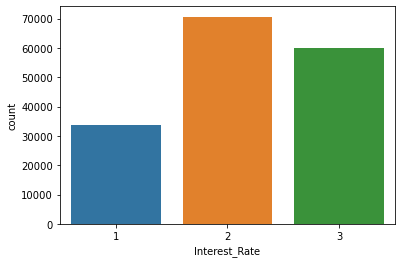

In [63]:
sns.countplot(train_df["Interest_Rate"])

### Univariate Analysis & Missing Value_Treatment

In [64]:
train=train_df.append(test_df,sort=False)

In [65]:
train.columns

Index(['Loan_ID', 'Loan_Amount_Requested', 'Length_Employed', 'Home_Owner', 'Annual_Income', 'Income_Verified', 'Purpose_Of_Loan', 'Debt_To_Income', 'Inquiries_Last_6Mo', 'Months_Since_Deliquency', 'Number_Open_Accounts', 'Total_Accounts', 'Gender', 'Interest_Rate'], dtype='object')

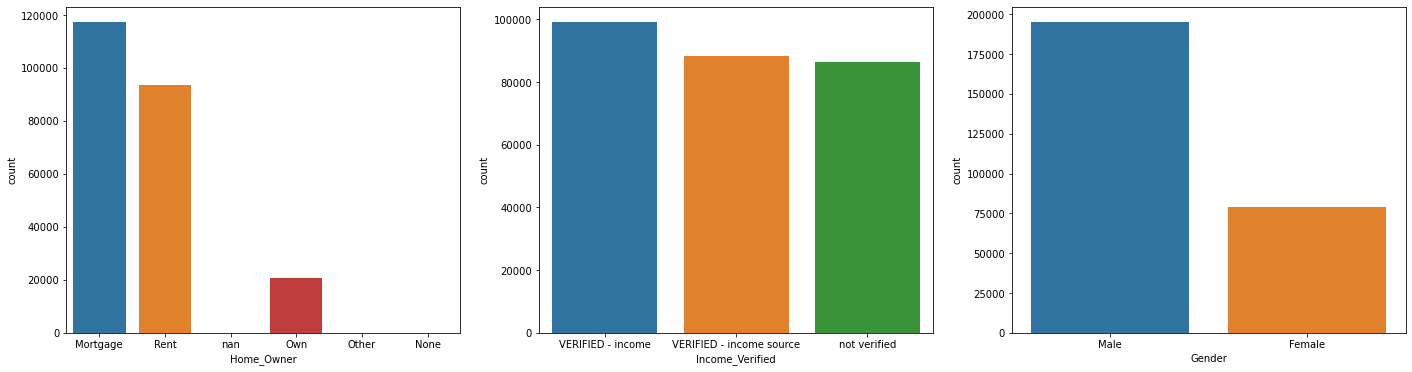

In [66]:
plt.figure(figsize=(24, 6))
plt.subplot(131)
sns.countplot(train['Home_Owner'],order = train['Home_Owner'].value_counts(dropna=False).index)
plt.subplot(132)
sns.countplot(train['Income_Verified'],order = train['Income_Verified'].value_counts(dropna=False).index)
plt.subplot(133)
sns.countplot(train['Gender'],order = train['Gender'].value_counts(dropna=False).index)

In [67]:
train['Home_Owner'].value_counts(dropna=False,normalize=True)

Mortgage    0.428227
Rent        0.341581
NaN         0.153588
Own         0.076242
Other       0.000288
None        0.000073
Name: Home_Owner, dtype: float64

Home Owner Variable contains 15% of data,Which more than other category, so it is handles as seperate Variable

In [68]:
train.Home_Owner.fillna('Unknown',inplace=True)

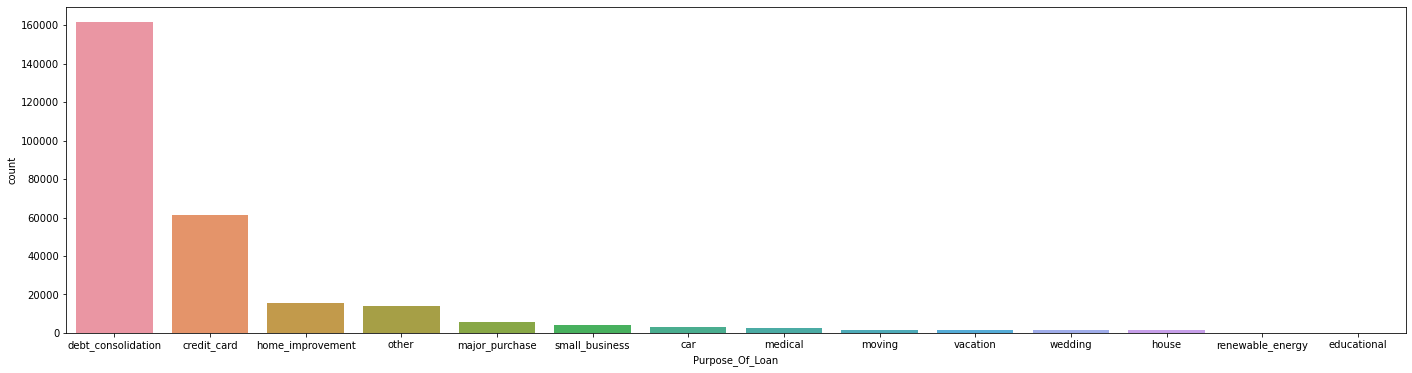

In [69]:
plt.figure(figsize=(24, 6))
sns.countplot(train['Purpose_Of_Loan'],order = train['Purpose_Of_Loan'].value_counts(dropna=False).index)

In [70]:
train['Months_Since_Deliquency'].value_counts(dropna=False,normalize=True)

NaN      0.537659
9.0      0.009439
8.0      0.009184
13.0     0.009114
12.0     0.009030
10.0     0.008994
14.0     0.008899
6.0      0.008684
15.0     0.008651
7.0      0.008651
18.0     0.008516
19.0     0.008286
11.0     0.008242
17.0     0.008187
16.0     0.008154
20.0     0.008023
21.0     0.007665
27.0     0.007548
23.0     0.007413
22.0     0.007354
26.0     0.007318
25.0     0.007216
28.0     0.007124
24.0     0.007102
29.0     0.006894
33.0     0.006880
31.0     0.006865
5.0      0.006796
30.0     0.006777
35.0     0.006639
34.0     0.006613
36.0     0.006609
38.0     0.006544
32.0     0.006500
42.0     0.006357
37.0     0.006321
39.0     0.006233
45.0     0.006171
40.0     0.006146
41.0     0.006032
44.0     0.006018
43.0     0.005989
48.0     0.005919
46.0     0.005890
47.0     0.005828
4.0      0.005817
49.0     0.004926
3.0      0.004477
50.0     0.004177
51.0     0.004148
54.0     0.004119
53.0     0.004079
55.0     0.004072
52.0     0.004020
57.0     0.004017
56.0     0

50% Data, is Missing in *Months_Since_Deliquency* Variable, ***Model Built with avoiding this variable gave poor accuracy than***, Substuting the variable with dummy number.

In [71]:
train.Months_Since_Deliquency.fillna(9999,inplace=True)

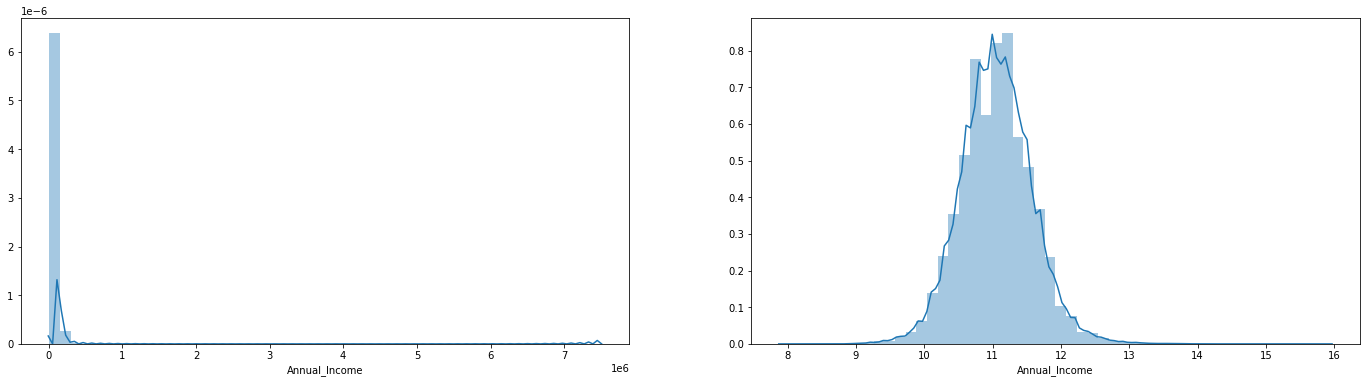

In [72]:
plt.figure(figsize=(24, 6))
plt.subplot(121)
sns.distplot(train["Annual_Income"])
plt.subplot(122)
sns.distplot(np.log1p(train["Annual_Income"]))
plt.show()

In [73]:
train['Annual_Income']=np.log1p(train["Annual_Income"])
train.Annual_Income.fillna(train.Annual_Income.median(),inplace=True)

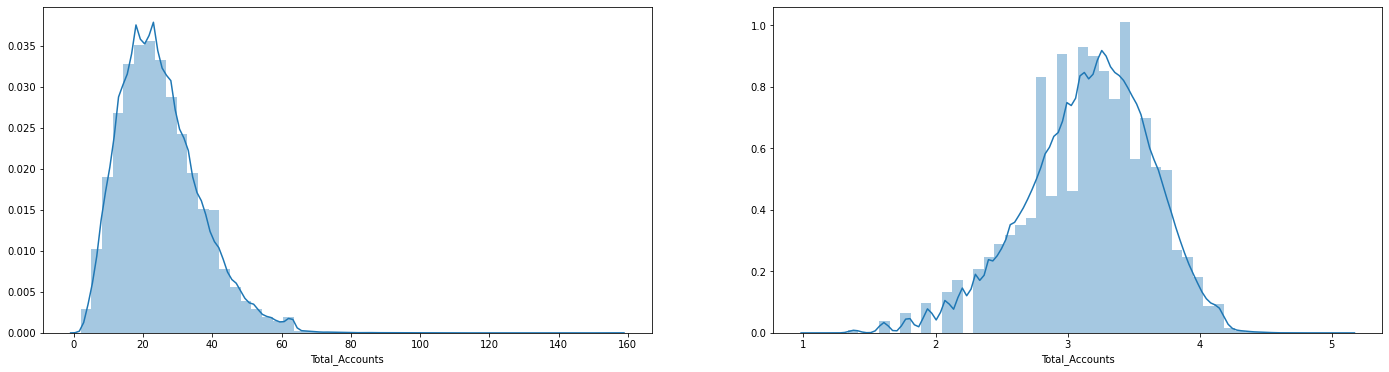

In [74]:
plt.figure(figsize=(24, 6))
plt.subplot(121)
sns.distplot(train["Total_Accounts"])
plt.subplot(122)
sns.distplot(np.log1p(train["Total_Accounts"]))
plt.show()

In [75]:
train['Total_Accounts']=np.log1p(train["Total_Accounts"])

In [76]:
train.Length_Employed.value_counts(dropna=False,normalize=True)

10+ years    0.322542
2 years      0.089173
3 years      0.078430
< 1 year     0.077170
5 years      0.065883
1 year       0.063305
4 years      0.059861
7 years      0.056396
6 years      0.056056
8 years      0.047891
NaN          0.044941
9 years      0.038353
Name: Length_Employed, dtype: float64

Length_Employed is equally Distributed Among, Working years, So I have added as Seperate Variable, I Didn't tried using Mode because it cotributes only 30%

In [77]:
train.Length_Employed.fillna(99,inplace=True)
train.Length_Employed.replace({'10+ years':'10 years','< 1 year': '0 year'},inplace= True)
train.Length_Employed=train.Length_Employed.apply(lambda x: ''.join(re.findall('\d+',str(x))))
train.Length_Employed=train.Length_Employed.astype(int)

Loan Amount Request contain ',', so it becames object type data, So it has to converted as Numerical Data

In [78]:
train.Loan_Amount_Requested=train.Loan_Amount_Requested.apply(lambda x: x.replace(',',''))
train.Loan_Amount_Requested=train.Loan_Amount_Requested.astype(int)

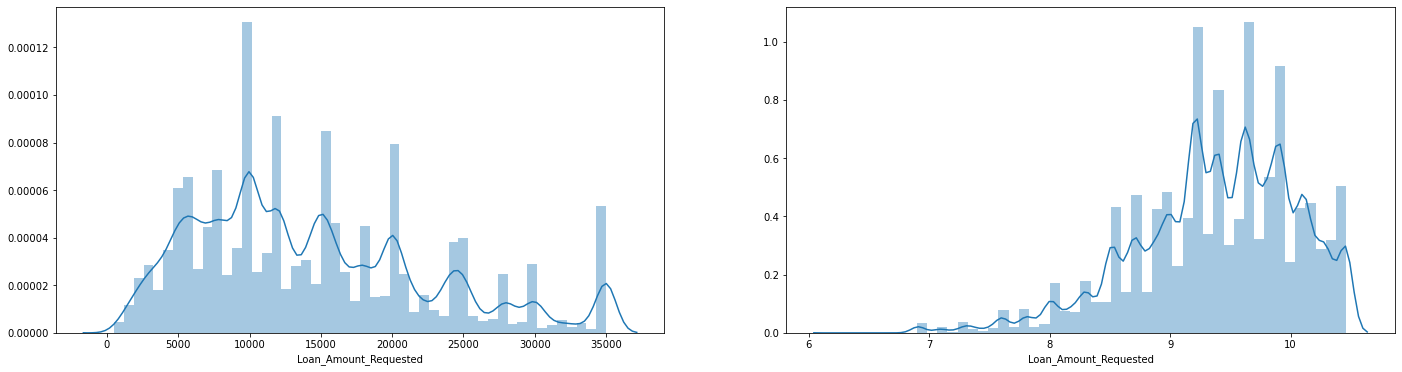

In [79]:
plt.figure(figsize=(24, 6))
plt.subplot(121)
sns.distplot(train["Loan_Amount_Requested"])
plt.subplot(122)
sns.distplot(np.log1p(train["Loan_Amount_Requested"]))
plt.show()

In [80]:
train['Loan_Amount_Requested']=np.log1p(train["Loan_Amount_Requested"]) #Normalizing not making much difference

In [81]:
train_df.shape,test_df.shape

((164309, 14), (109541, 13))

In [82]:
train_df=train[:164309]
test_df=train[164309:]

# Model Building

In [83]:
# Set up folds
K = 5
skf = StratifiedKFold(n_splits = K, random_state = 7, shuffle = True)

In [84]:
cat_columns=train_df.select_dtypes(include='object').columns.tolist()
cat_columns.extend(['Length_Employed']) #Considering the Length_Employed as Category increased the Accuracy
# To specify categorical variables indexes
cat_columns

['Home_Owner',
 'Income_Verified',
 'Purpose_Of_Loan',
 'Gender',
 'Length_Employed']

*Learned from AV Hackathon Janatahack Solution*

In [ ]:
X = train_df.drop(columns=['Loan_ID','Interest_Rate'],axis=1)
y = train_df['Interest_Rate']
X_test = test_df.drop(columns=['Loan_ID'],axis=1)
y_valid_pred = 0*y
y_test_pred = 0
accuracy = 0
result={}
#fitting catboost classifier model
j=1
model = CatBoostClassifier(n_estimators=1000,verbose=False,learning_rate=0.1)
for train_index, test_index in skf.split(X, y):  
    # Create data for this fold
    y_train, y_valid = y.iloc[train_index], y.iloc[test_index]
    X_train, X_valid = X.iloc[train_index,:], X.iloc[test_index,:]
    print( "\nFold ", j)
    
    # Run model for this fold
    fit_model = model.fit( X_train, y_train, eval_set=(X_valid, y_valid),cat_features=cat_columns, use_best_model=True)
    print( "  N trees = ", model.tree_count_ )
        
    # Generate validation predictions for this fold
    pred = fit_model.predict(X_valid)
    y_valid_pred.iloc[test_index] = pred.reshape(-1)
    print(accuracy_score(y_valid,pred))
    accuracy+=accuracy_score(y_valid,pred)
    # Accumulate test set predictions
    y_test_pred += fit_model.predict(X_test)
    result[j]=fit_model.predict(X_test)
    j+=1
results = y_test_pred / K  # Average test set predictions
print(accuracy/5)


Fold  1


### Solution

In [ ]:
prediction = pd.DataFrame()
for i in range(1, 6):
    prediction = pd.concat([prediction,pd.DataFrame(result[i])],axis=1)
prediction.columns=['Split1','Split2','Split3','Split4','Split5']

In [ ]:
submission.Interest_Rate=prediction.mode(axis=1)[0]
submission.to_csv('stratifiedkfold_CatBoost_final.csv',index = False)